In [1]:
import sys
import pickle

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from libemg.utils import get_windows

sys.path.append('../')
from lift.simulator.simulator import WindowSimulator
from lift.datasets import get_mad_sample
from configs import BaseConfig
config = BaseConfig()

In [8]:
data_path = '../datasets/MyoArmbandDataset/PreTrainingDataset/Female0/training0/'
emg_list, label_list = get_mad_sample(data_path, filter_labels = True)
sort_id = np.argsort(label_list)
label_list = [label_list[i] for i in sort_id]
emg_list = [emg_list[i] for i in sort_id]
# I used labels 0 - 4 (including 4), where label 0 is rest

min_len = min([len(emg) for emg in emg_list])
short_emgs = [emg[:min_len,:] for emg in emg_list]
windows_list = [get_windows(s_emg, 200, 200) for s_emg in short_emgs]
windows = np.concatenate(windows_list, axis=0)
n_repeats = windows_list[0].shape[0]
short_labels = torch.tensor(np.concatenate([np.repeat(label, repeats=n_repeats) for label in label_list]))
actions = F.one_hot(short_labels, num_classes=5).float()

In [9]:
sim = WindowSimulator(num_actions=5, num_bursts=5, num_channels=8, window_size=200)

In [10]:
with open('../best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

In [11]:
sim.set_params(
    torch.from_numpy(best_params['bias_range']).to(torch.float32), 
    torch.from_numpy(best_params['emg_range']).to(torch.float32),
)

In [12]:
sim_windows = sim(actions)

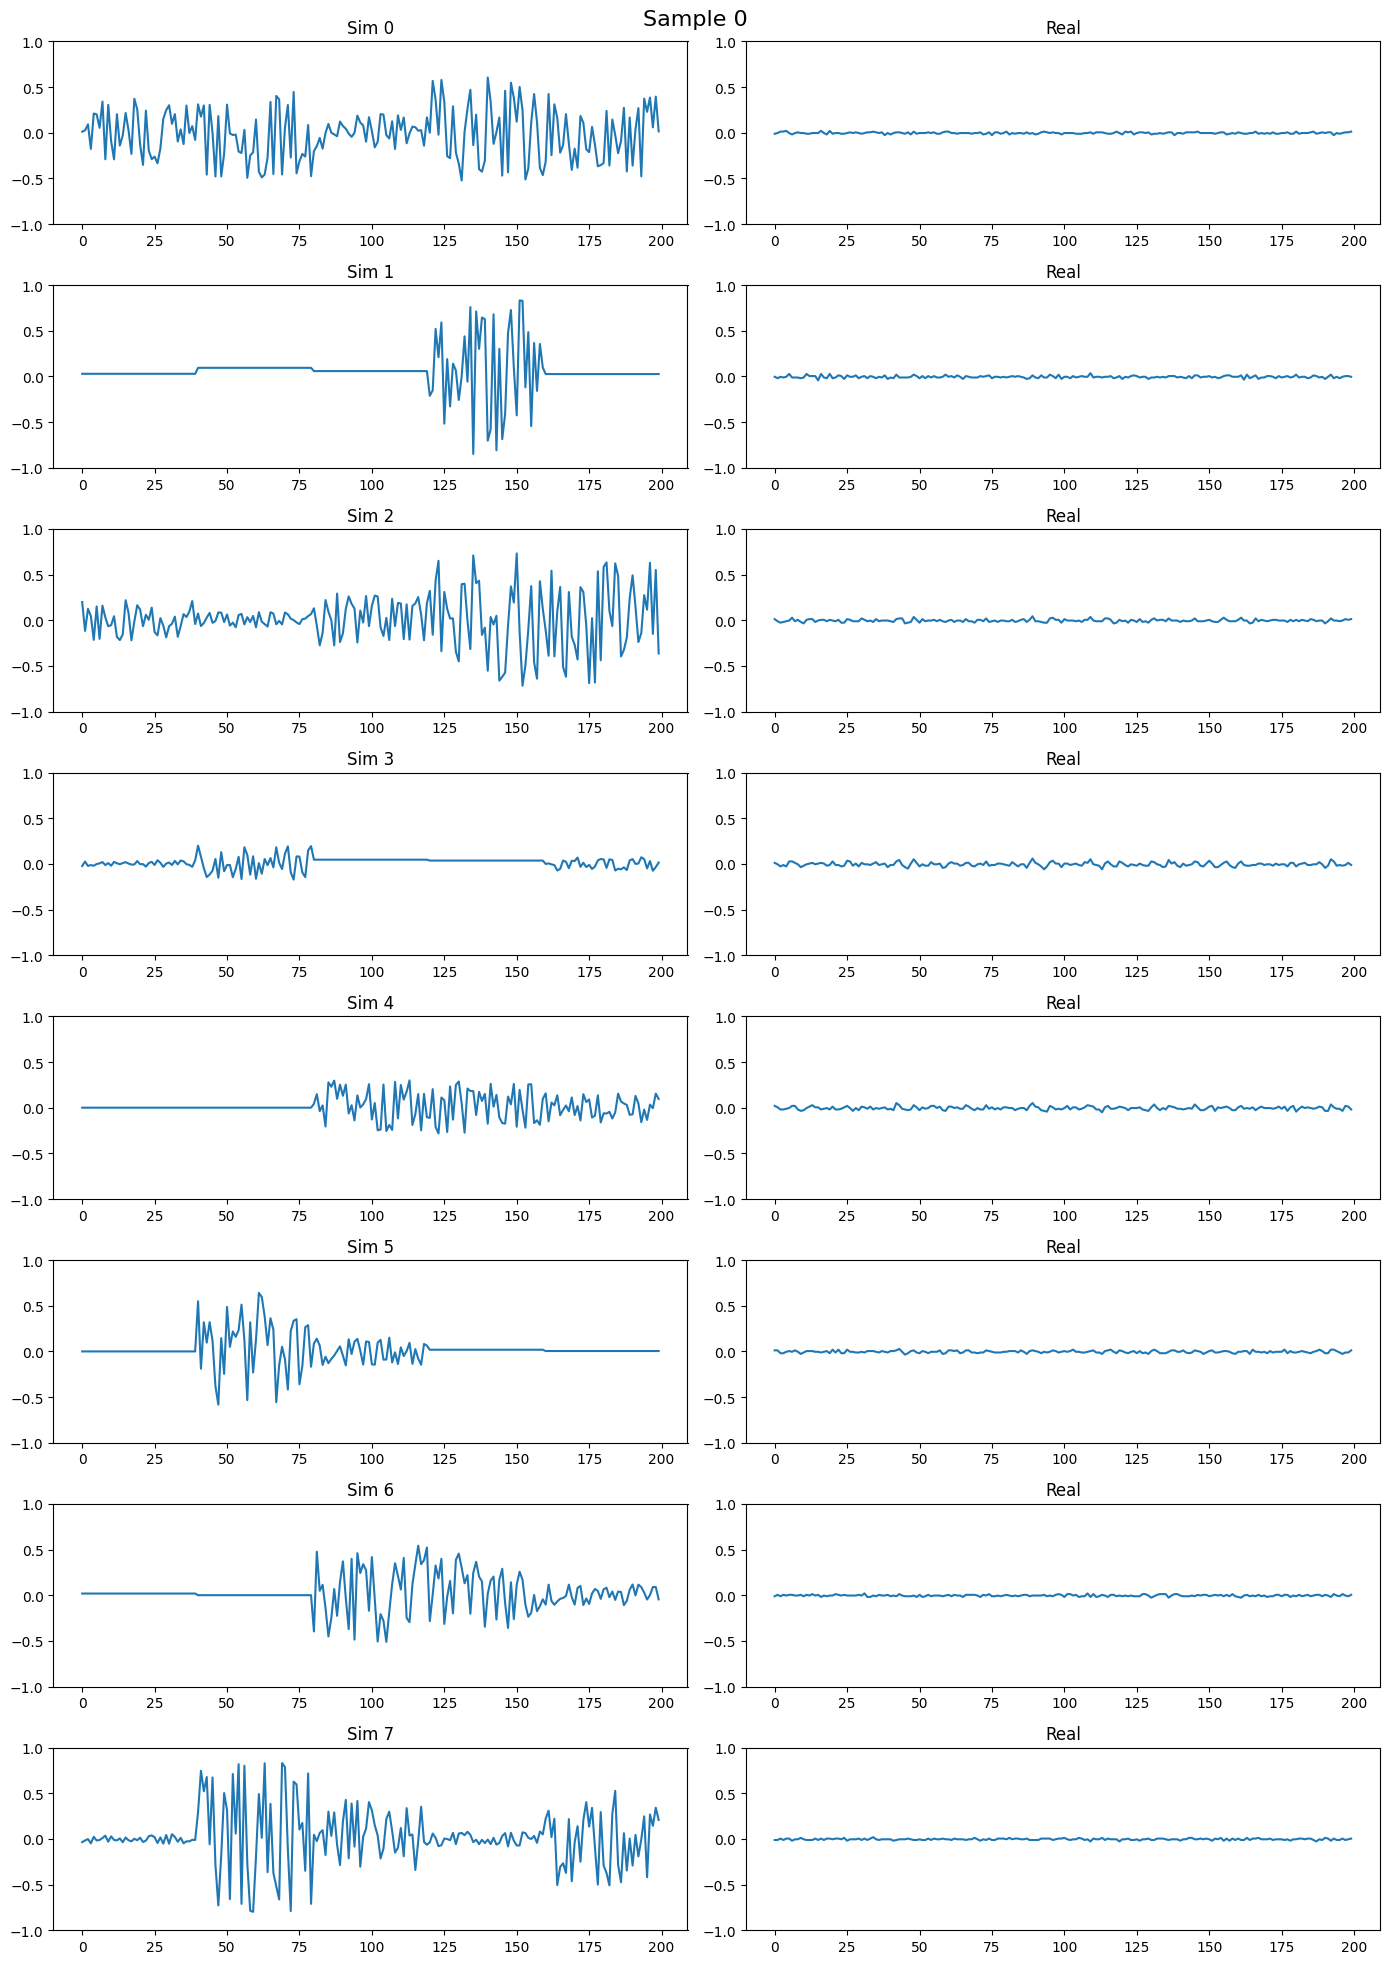

In [13]:
sample_idx = 0
n_channels = windows.shape[1]
fig, axs = plt.subplots(n_channels,2, figsize=(14,20))
for channel_idx in range(n_channels):
    axs[channel_idx,0].plot(sim_windows[sample_idx,channel_idx,:])
    axs[channel_idx,0].set_title(f'Sim {channel_idx}')
    axs[channel_idx,0].set_ylim(-1, 1)
    axs[channel_idx,1].plot(windows[sample_idx,channel_idx,:])
    axs[channel_idx,1].set_title('Real')
    axs[channel_idx,1].set_ylim(-1, 1)
fig.suptitle(f'Sample {sample_idx}', fontsize=16)
plt.tight_layout()
plt.show()

thinks to consider
- Is the objective correct?
- Is optimizing for features fine?
- why are some part just 0? (especially sample 0, channel 1)

**TODO**   
- Check if objective corresponds with closer EMG